In [89]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from src.functions import *
from src.params import *
from omegaconf import OmegaConf
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In models folder, there are two python files, sm_models and sm_models_d.

The first one contains the solution based on the PINNSIM/ Ignasi's model, while the second is based on the Power Dynamics formulation. Their major difference is the value of damping torque. According to Sauer and Pi book p.105, where 5.157 is followed by Power Dynamics and 5.158 is used for the other solution. As a result the value of D should be altered accordingly.

Check also p.130 and p.131 3.203 eq. Kundur where instead of altering D, the divide omega-omega_B by omega_B,
and also p.730 eq 12.78 for the formulation that matches PINNSIM.

p.190 8.25 equation and p.223 eq. 9.8


The third book: p.375 PSS

Two models were implemented, Sauer & Pi and Kundur

In [90]:
from src.ode.sm_models import SynchronousMachineModels

Specify all the parameters of the models and also the initial values for AVR and GOV

In [91]:
def return_params(model_number, modeling_flag):
    "Synchronous machine parameters"
    H0 , X_d0, X_d_dash0, X_q0, X_q_dash0, T_d_dash0, T_q_dash0, D0, Rs0, P_m0, E_fd0 = matrix.loc[model_number]
    param_freq = 50
    #P_m0 = 0.1  #SOS IF CHANGE THEY CONVERGE @@@@@
    #D0 = 0.5
    #H0 = 2 
    #X_d0 = 2.5

    "AVR parameters from IEEE 14 bus system/ power dynamics"
    K_A0=20
    T_A0=0.2
    K_E0=1.0
    T_E0=0.314
    K_F0=0.063
    T_F0=0.35



    "V_ref SOSOS following page 190 Sauer and Pi is calculated within the model class"
    V_ref0=1.095
    "GOV parameters from Power Dynamics and Sauer and Pi p.86"
    P_c = 0.7
    R_d = 0.05
    T_ch = 0.4 
    T_sv = 0.2
    "system parameters following good practice"
    omega_B0=2 * np.pi * param_freq
    Vs0=1
    theta_vs0=0

    "return parameters for the various models"
    if modeling_flag == "SM":
        return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0]
    
    
    if modeling_flag == "SM_AVR":
        return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0]
    if modeling_flag == "SM_AVR_GOV":
        return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0, P_c, R_d, T_ch, T_sv]                
    return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0]


def return_initial_conditions(model_number, delta, omega, E_d_dash, E_q_dash, modeling_flag):

    'Initial values'
    "Infinite bus and 2 axis model initial conditions"
    delta0=delta
    omega0=omega
    E_d_dash0=E_d_dash
    E_q_dash0=E_q_dash
    
    if modeling_flag == "SM" or modeling_flag == "SM_IB":
        return [delta0, omega0, E_d_dash0, E_q_dash0]
    
    "AVR initial conditions"
    V_r0=1.105
    R_F0= 1

    "AVR parameters from IEEE 14 bus system/ power dynamics"
    K_A0=20
    T_A0=0.2
    K_E0=1.0
    T_E0=0.314
    K_F0=0.063
    T_F0=0.35

    "calculated following Sauer and Pi p.190 example"
    "using the initial conditions from above for the current calculation"
    H0 , X_d0, X_d_dash0, X_q0, X_q_dash0, T_d_dash0, T_q_dash0, D0, Rs0, P_m0, E_fd0 = matrix.loc[model_number]
    
    theta_vs0=0
    Vs0=1
    I_d, I_q = calculate_current (theta_vs0, E_d_dash0, E_q_dash0, X_d_dash0, X_q_dash0, Rs0, Vs0, theta_vs0)

    E_fd0=E_q_dash0 + (X_d0 - X_d_dash0) * I_d
    R_F0=K_F0/T_F0*E_fd0
    V_r0=(K_E0 +0.098 * np.e**(E_fd0*0.55)) * E_fd0
    
    if modeling_flag == "SM_AVR":
        R_F0 =1
        V_r0 = 0.05
        E_fd0 = 0
        return [delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0]
    
    "GOV initial conditions"
    P_sv0 = 0.7048 # solving p.86 in Sauer and Pi book ex. 4.8a 
    P_m0 = 0.7048 # same as above
    if modeling_flag == "SM_AVR_GOV":
        return [delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, P_sv0]                
    return [delta0, omega0, E_d_dash0, E_q_dash0]



In [119]:
def solve_model(time, model_number, modeling_flag ,version_flag,plot=False):
    # -0.3957,  0.1515,  0.0000,  0.5689 3.8463e-01,  1.5152e-01,  0.0000e+00,  5.6887e-01
    Delta_range       = [ 0.38463] 
    Omega_range      = [50] #0.15152*(2 * np.pi*50)
    E_d_dash_f    = 0
    E_q_dash    = [1.1]

    num_ranges_omega  = 1 # change to 1 if want only 1 trajectory
    num_ranges_delta  = 1 # change to 1 if want only 1 trajectory

    solution_all = []   
    for i in range(num_ranges_delta):
        delta = (Delta_range[0] + i * (Delta_range[1] - Delta_range[0]) / (num_ranges_delta - 1) if num_ranges_delta > 1 else Delta_range[0])
        for j in range(num_ranges_omega):
            omega = (Omega_range[0] + j * (Omega_range[1] - Omega_range[0]) / (num_ranges_omega - 1) if num_ranges_omega > 1 else Omega_range[0])
            for k in E_q_dash:
                E_q_dash_f = k
                t=time
                number_of_points=5000
                x=return_initial_conditions(model_number, delta, omega, E_d_dash_f, E_q_dash_f, modeling_flag)
                params=return_params(model_number, modeling_flag)
                #print(x)
                solver = SynchronousMachineModels(t, number_of_points, x, params, modeling_flag)#x, params, not_ib_flag, avr_flag, gov_flag
                solution , model = solver.solve(x, version_flag) # change flag to False to use the other modeling approach
                solution_all.append(solution)
    #print(x, "init")
    #print(params, "params")
    return solution_all




In [93]:
def plot_sol(sol,var,modelling):
    plt.figure(figsize=(10, 6))
    for i in range(len(sol)):
        solution = sol[i]
        plt.plot(solution.t, solution.y[var], label='Theta (pu)')
        #plt.plot(solution.t, solution.y[1], label='Omega (pu)')
    plt.title(modelling)
    plt.xlabel('Time (s)')
    plt.ylabel('Values (pu)')
    plt.show()
    return

All the combinations for flag system

flag = "SM_IB" or "SM" or "SM_AVR" or "SM_AVR_GOV"

Specify initial values for delta, omega... and model = 0

Version flag: # check src.ode.sm_models

1 Choose the formulation without multiplying D with omega_s

2 Choose the formulation with multiplying D with omega_s

Change flags to check different combinations

Time taken in seconds:  0.9704818725585938
0.019409637451171875
[5.00000000e+01 4.83935952e+01 4.68210414e+01 ... 2.32588933e-04
 2.32492632e-04 2.32396229e-04]


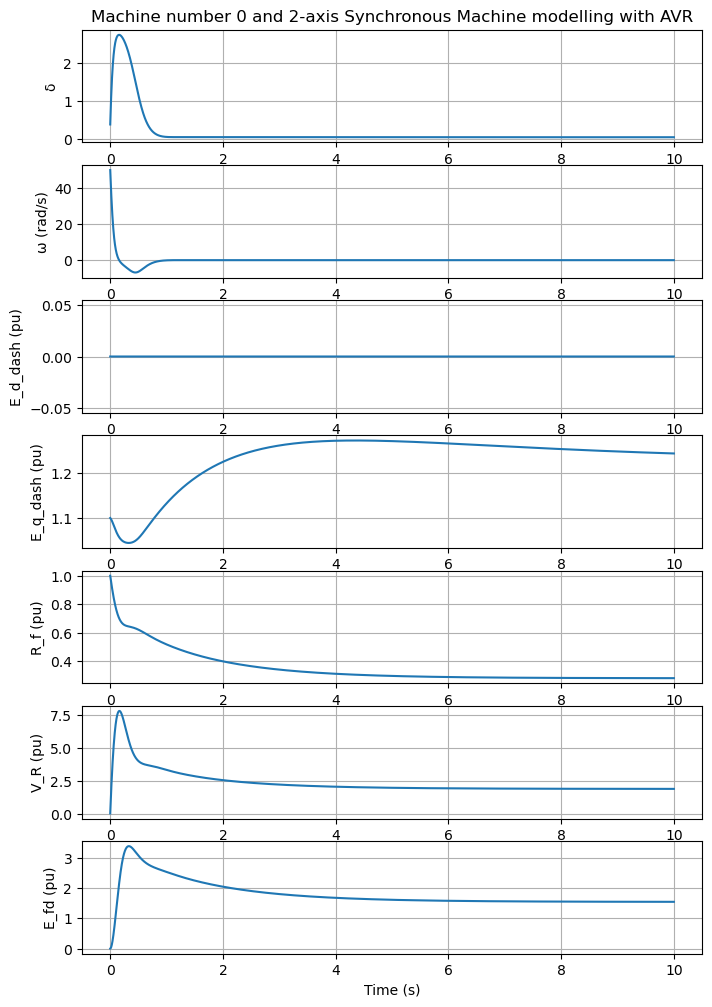

In [120]:
# count time for execution
import time

start = time.time()


model_num = 0
time0 = 10
flag = "SM_AVR"
for i in range(50):
    sol=solve_model(time0, model_num, modeling_flag=flag, version_flag=True)
end = time.time()
print("Time taken in seconds: ", end - start)
print((end-start)/50)
print(sol[0].y[1])
#plot_sol(sol,8,flag)
plotting_solution_gridspec_original_all(sol,"0 and 2-axis Synchronous Machine modelling with AVR",False)




All the combinations

Set True only one flag each time:

not_ib_flag = True ->2 axis model\
avr_flag    = True ->2 axis model with AVR\
gov_flag    = True ->2 axis model with AVR and Governor\
all False   -> Infinite bus model

In [95]:
solution = {}
models = ["SM_IB","SM", "SM_AVR", "SM_AVR_GOV"]
for j in range(len(models)):
    for i in range(7):
        #print("Selected Model: ",i)
        #append the solution solve_model(i, not_ib_flag,avr_flag,gov_flag)
        time = 20
        solution[j,i]=solve_model(time, i,models[j],version_flag= True)
        

In [96]:
solution[3,3]

[  message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  4.001e-03 ...  2.000e+01  2.000e+01]
         y: [[ 3.846e-01  5.625e-01 ...  3.351e-01  3.351e-01]
             [ 5.000e+01  3.913e+01 ... -1.542e-04 -1.540e-04]
             ...
             [ 7.048e-01  7.045e-01 ...  7.000e-01  7.000e-01]
             [ 7.048e-01  6.486e-01 ...  7.000e-01  7.000e-01]]
       sol: None
  t_events: None
  y_events: None
      nfev: 2594
      njev: 0
       nlu: 0]

Change  number that has comment to plot the solution for different initial conditions

Model:  0


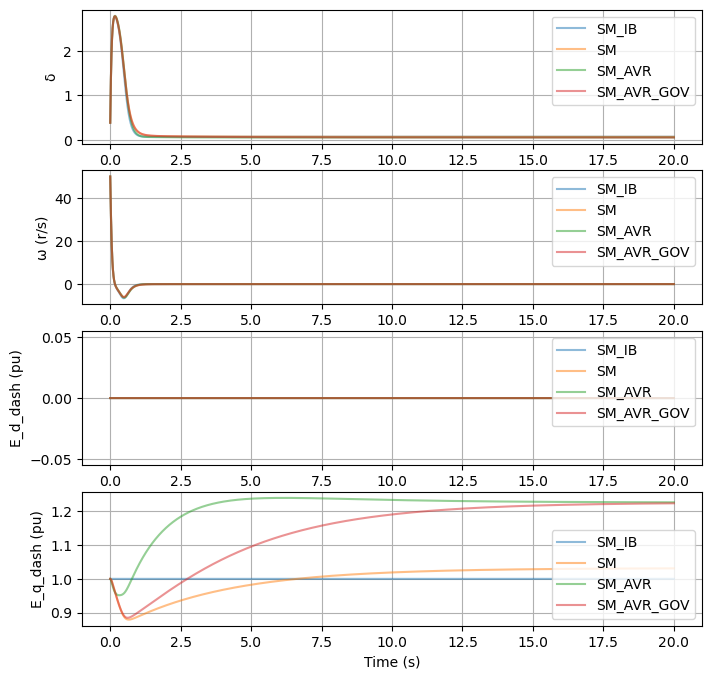

Model:  1


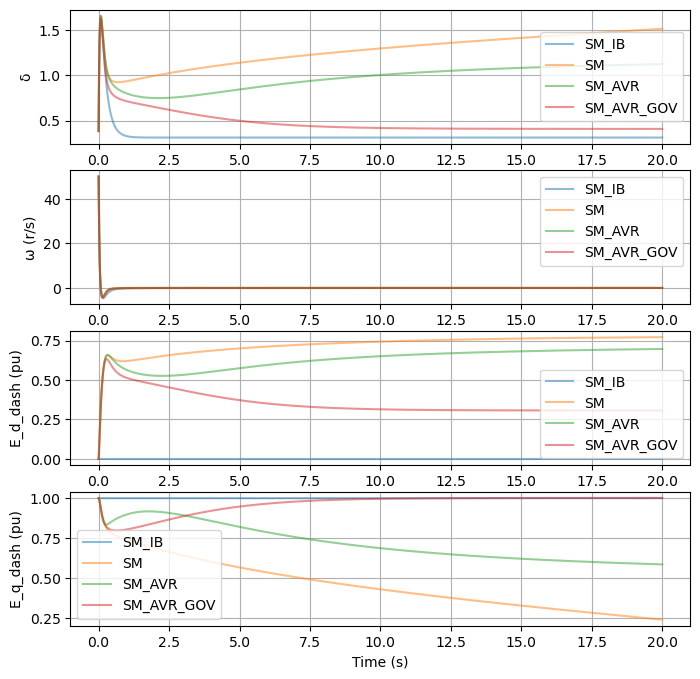

Model:  2


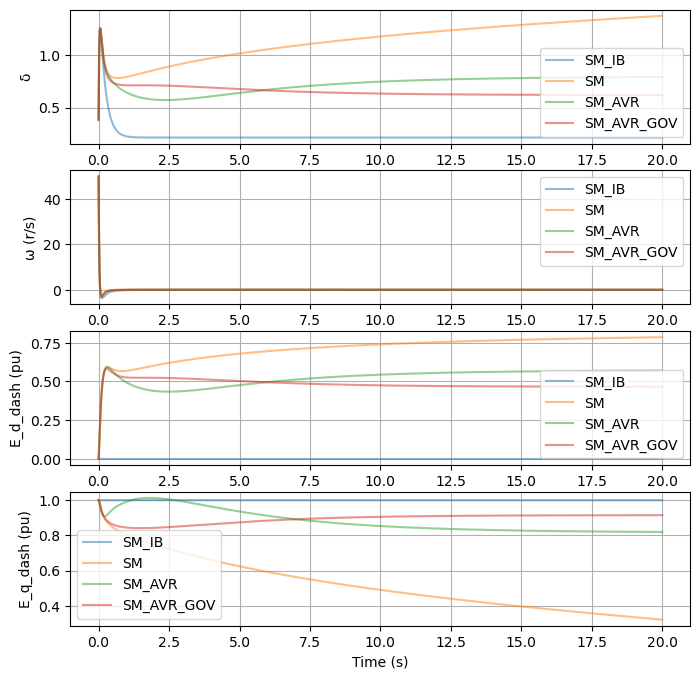

Model:  3


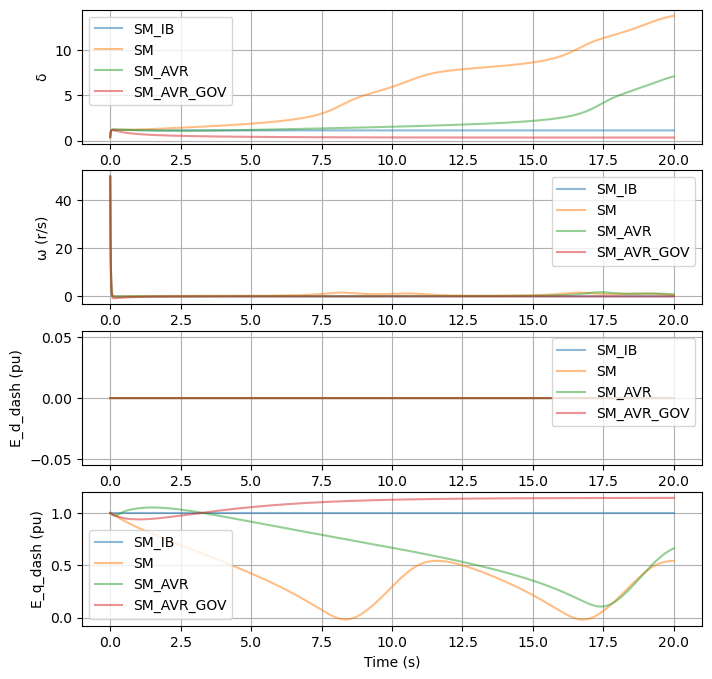

Model:  4


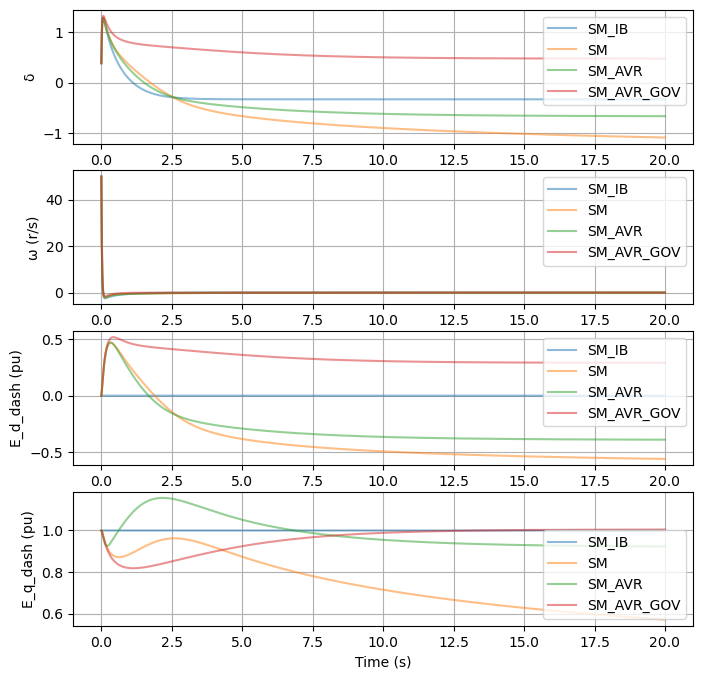

Model:  5


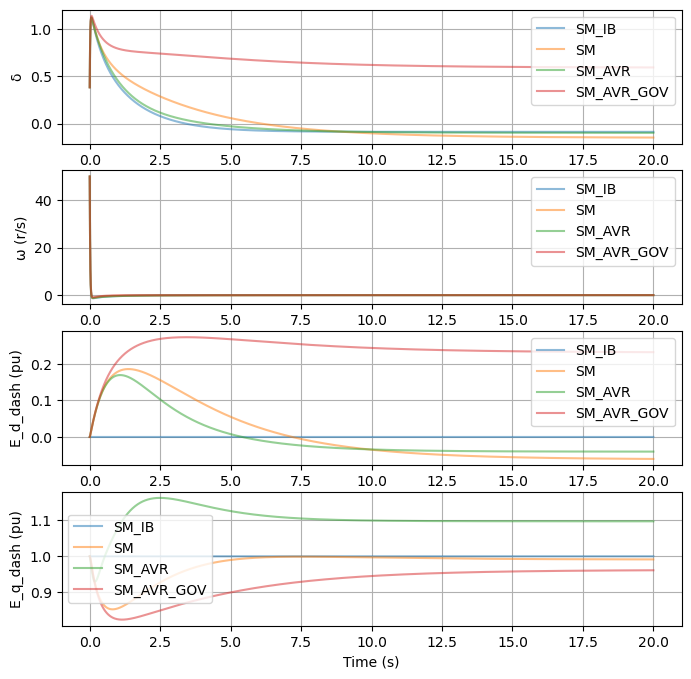

Model:  6


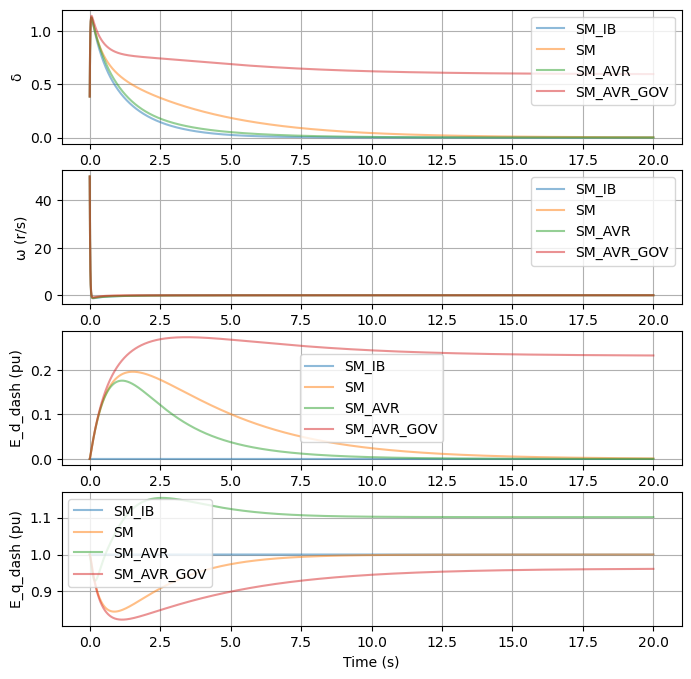

In [99]:
# Plotting the solution with gridspec
def plotting_solution_gridspec_all_old(solution):
    flag = ["SM_IB","SM", "SM_AVR", "SM_AVR_GOV"]
    for i in range(7):
        print("Model: ",i)
        fig, axs = plt.subplots(4, 1, figsize=(8, 8))
        # add title
        #fig.suptitle('Machine number: '+str(i))
        for j in range(len(flag)):
            sol=solution[j,i][0]  #Change this number to check different initial conditions
            axs[0].plot(sol.t, sol.y[0], label=flag[j],alpha=0.5)
            axs[0].set_ylabel('δ')
            axs[0].legend()
            axs[0].grid(True)
            
            axs[1].plot(sol.t, sol.y[1], label=flag[j],alpha=0.5)
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('ω (r/s)')
            axs[1].legend()
            axs[1].grid(True)
            
            axs[2].plot(sol.t, sol.y[2], label=flag[j],alpha=0.5)
            axs[2].set_xlabel('Time (s)')
            axs[2].set_ylabel('E_d_dash (pu)')
            axs[2].legend()
            axs[2].grid(True)
            
            axs[3].plot(sol.t, sol.y[3], label=flag[j],alpha=0.5)
            axs[3].set_xlabel('Time (s)')
            axs[3].set_ylabel('E_q_dash (pu)')
            axs[3].legend()
            axs[3].grid(True)
        
        plt.show()
    return None
def plotting_solution_gridspec_all(solution):
    flag = ["SM_IB","SM", "SM_AVR", "SM_AVR_GOV"]
    for i in range(7):
        print("Model: ",i)
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        
        for j in range(len(flag)):
            sol=solution[j,i][0]  #Change this number to check different initial conditions
            axs[0].plot(sol.t, sol.y[0], label=flag[j],alpha=0.5)
            axs[0].set_ylabel('δ')
            axs[0].legend()
            axs[0].grid(True)
            
            axs[1].plot(sol.t, sol.y[1], label=flag[j],alpha=0.5)
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('ω (r/s)')
            axs[1].legend()
            axs[1].grid(True)
        plt.show()
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        for j in range(len(flag)):
            axs[0].plot(sol.t, sol.y[2], label=flag[j],alpha=0.5)
            axs[0].set_xlabel('Time (s)')
            axs[0].set_ylabel('E_d_dash (pu)')
            axs[0].legend()
            axs[0].grid(True)
            
            axs[1].plot(sol.t, sol.y[3], label=flag[j],alpha=0.5)
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('E_q_dash (pu)')
            axs[1].legend()
            axs[1].grid(True)
        plt.show()
        """
        if flag == "SM_AVR" or flag == "SM_AVR_GOV":
            fig, axs = plt.subplots(2, 1, figsize=(8, 6))
            for j in range(len(flag)):
                axs[0].plot(sol.t, sol.y[4], label=flag[j],alpha=0.5)
                axs[0].set_xlabel('Time (s)')
                axs[0].set_ylabel('R_F (pu)')
                axs[0].legend()
                axs[0].grid(True)
                
                axs[1].plot(sol.t, sol.y[5], label=flag[j],alpha=0.5)
                axs[1].set_xlabel('Time (s)')
                axs[1].set_ylabel('V_r (pu)')
                axs[1].legend()
                axs[1].grid(True)
        plt.show()
        if flag == "SM_AVR_GOV":
            fig, axs = plt.subplots(3, 1, figsize=(8, 6))
            for j in range(len(flag)):
                axs[0].plot(sol.t, sol.y[6], label=flag[j],alpha=0.5)
                axs[0].set_xlabel('Time (s)')
                axs[0].set_ylabel('E_fd (pu)')
                axs[0].legend()
                axs[0].grid(True)
                
                axs[1].plot(sol.t, sol.y[7], label=flag[j],alpha=0.5)
                axs[1].set_xlabel('Time (s)')
                axs[1].set_ylabel('P_m (pu)')
                axs[1].legend()
                axs[1].grid(True)
                axs[2].plot(sol.t, sol.y[8], label=flag[j],alpha=0.5)
                axs[2].set_xlabel('Time (s)')
                axs[2].set_ylabel('P_sv (pu)')
                axs[2].legend()
                axs[2].grid(True)
            """
        plt.show()
    return None
#solution[j,i]
plotting_solution_gridspec_all_old(solution)

Plot the various models with initial state:

    delta0=0.3
    omega0=0.2
    E_d_dash0=0
    E_q_dash0=1

Model:  0


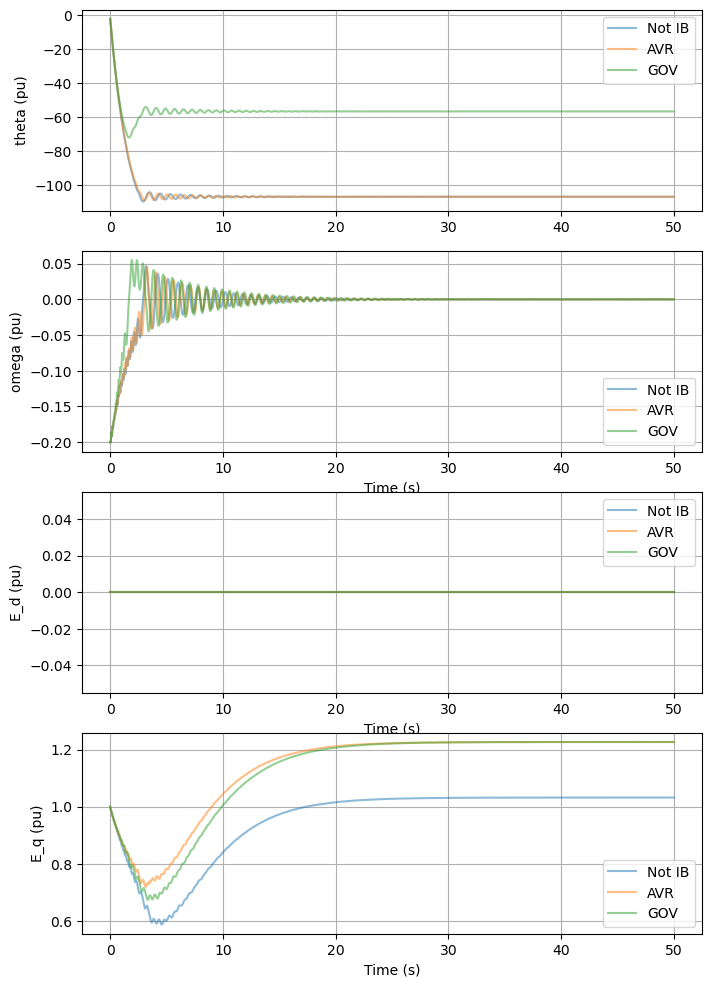

Model:  1


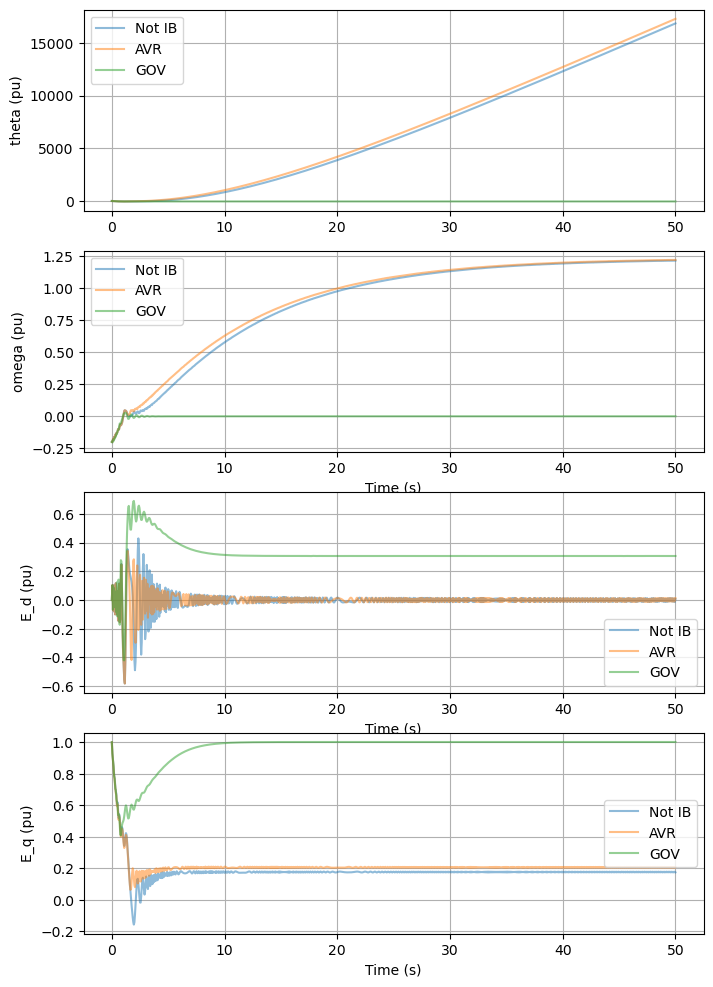

Model:  2


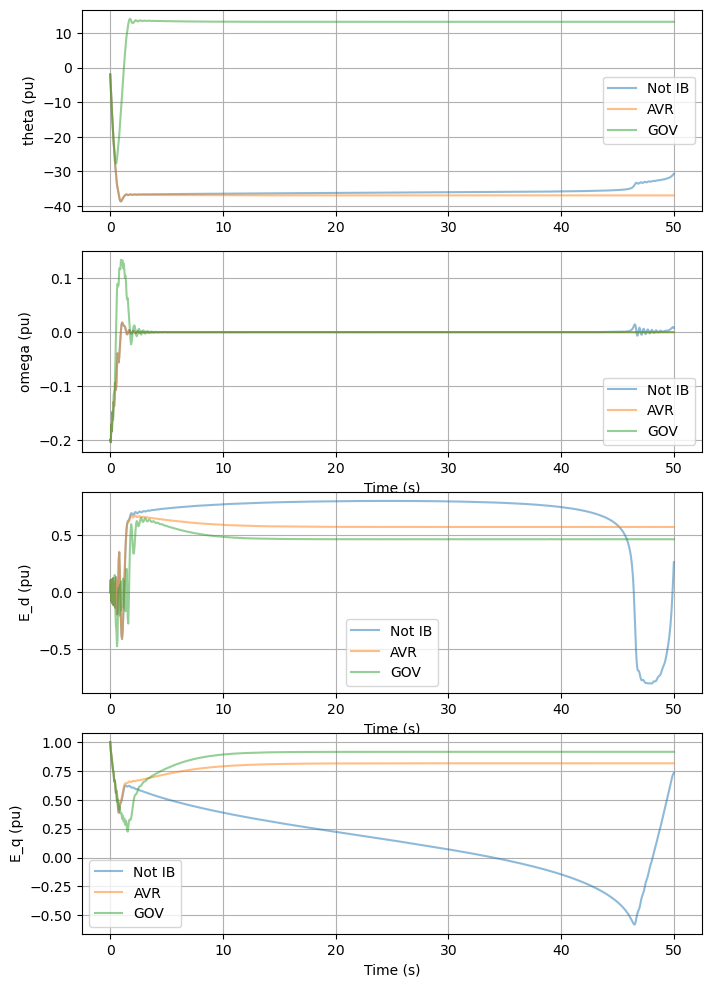

Model:  3


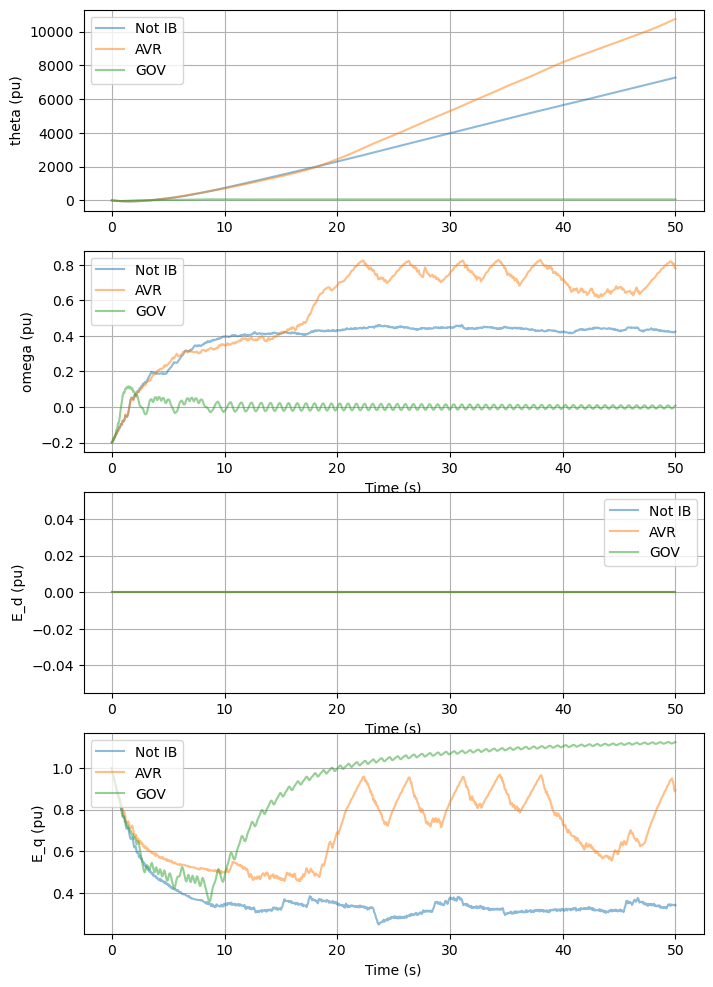

Model:  4


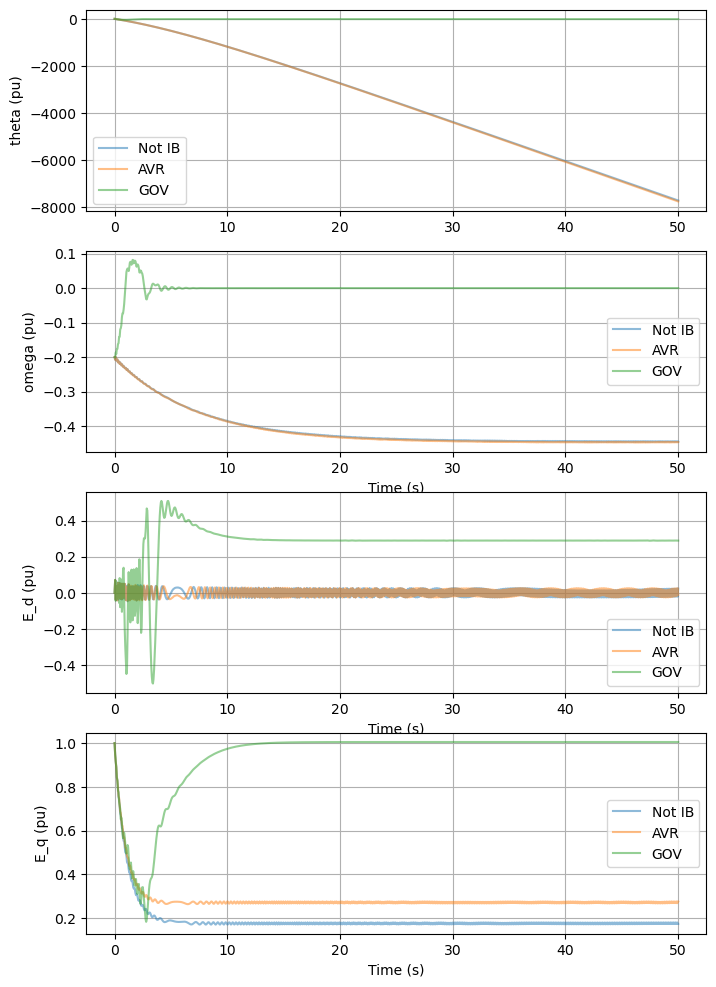

Model:  5


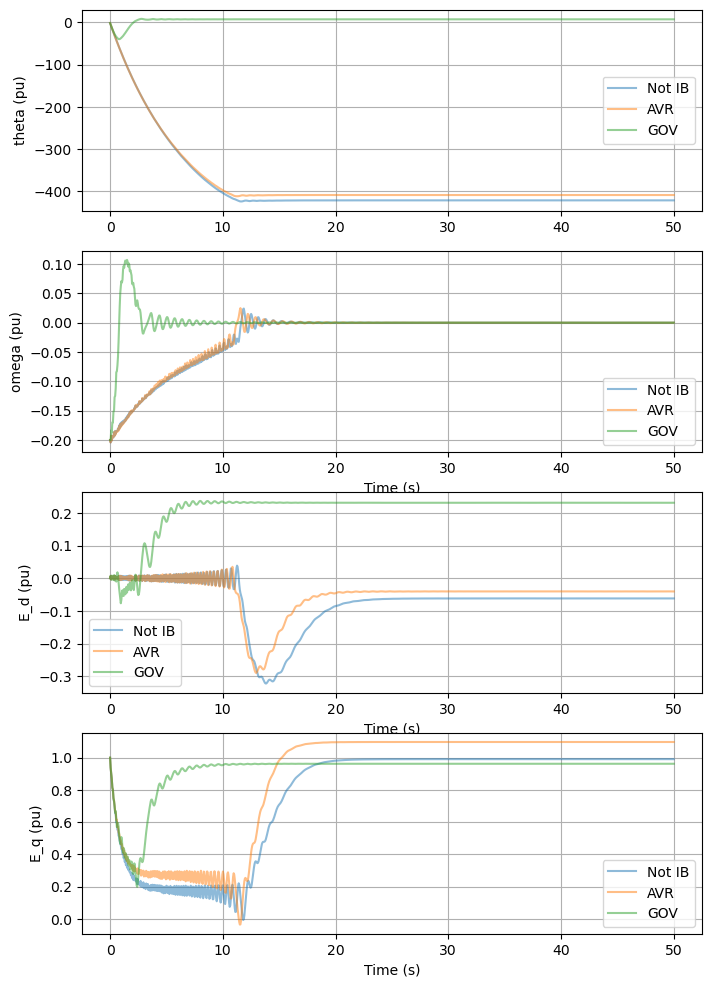

Model:  6


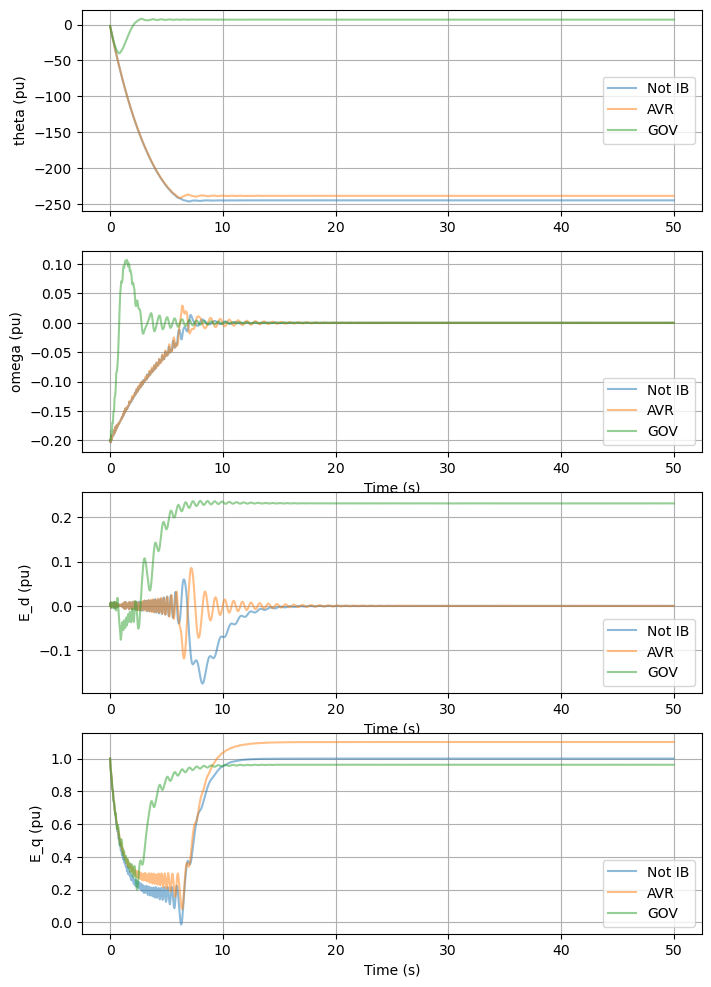

In [141]:
# Plotting the solution with gridspec
def plotting_solution_gridspec_all(solution):
    flag = ['Not IB', 'AVR', 'GOV']
    for i in range(7):
        print("Model: ",i)
        fig, axs = plt.subplots(4, 1, figsize=(8, 12))
        for j in range(3):
            sol=solution[j,i][0]
            axs[0].plot(sol.t, sol.y[0], label=flag[j],alpha=0.5)
            axs[0].set_ylabel('theta (pu)')
            axs[0].legend()
            axs[0].grid(True)
            
            axs[1].plot(sol.t, sol.y[1], label=flag[j],alpha=0.5)
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('omega (pu)')
            axs[1].legend()
            axs[1].grid(True)
            
            axs[2].plot(sol.t, sol.y[2], label=flag[j],alpha=0.5)
            axs[2].set_xlabel('Time (s)')
            axs[2].set_ylabel('E_d (pu)')
            axs[2].legend()
            axs[2].grid(True)
            
            axs[3].plot(sol.t, sol.y[3], label=flag[j],alpha=0.5)
            axs[3].set_xlabel('Time (s)')
            axs[3].set_ylabel('E_q (pu)')
            axs[3].legend()
            axs[3].grid(True)
        
        plt.show()
    return None

#solution[j,i]
plotting_solution_gridspec_all(solution)